In [1]:
#imports
import numpy as np
import os
import cv2
import xarray as xr
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000 #to adjust for RAM issues on my local

from pylab import *

### Custom Functions

In [2]:
def file_to_xr(filepath: str, index: bool, altitude: str, channel: str):
    """
    Function to import an image as a formatted xarray object
    """
    if index:
        arr = (cv2.imread(filepath, cv2.IMREAD_UNCHANGED).astype(np.float32))
        fname = 'index'
    else:
        arr = (cv2.imread(filepath, cv2.IMREAD_GRAYSCALE).astype(np.float32))
        fname = 'pixel'
    
    dim1 = arr.shape[0]
    dim2 = arr.shape[1]
    yrange = range(0,-1*dim1, -1) #not sure what to agree on for coords but putting (0,0) as top left and making y negative to stay cartesian
    xrange = range(0,dim2)
    test_xr = xr.DataArray(arr, coords={'altitude': altitude,'channel':channel, 'y': yrange,'x': xrange}, dims=["y", "x"], name=fname+'_'+altitude+'_'+channel)
    
    #cleaning
    if index:
        test_xr = test_xr.where(test_xr != -10000)
        test_xr = test_xr.where(test_xr < 254)  #to clean values from boxed regions

    test_xr = test_xr.to_dataset(name=fname+'-'+altitude+'-'+channel)
    return test_xr


In [4]:
def discrete_cmap(base_cmap, N):
    """Create an N-bin discrete colormap from the specified input map
    https://gist.github.com/jakevdp/91077b0cae40f8f8244a
    """
    base = matplotlib.colormaps[base_cmap] #plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

In [3]:
def plot_kmeans(km_array):
    """
    Plot clusters of kmeans against spectral bands
    Assumes in 
    """
    spectral_bands = [560,650,730,860] #from manufacturer
    
    plt.figure(figsize=(7,3.5))
    for y in range(0,len(km_array)):
        sns.lineplot(x=[560,650,730,860], y=km_array[y], label="C"+str(y), marker='o')
    plt.title('Cluster Centroids (before reordering)'); 
    plt.xlabel("Wavelength"); 
    plt.ylabel("Pixel Value");
    

In [13]:
def redefine_classes(kmeans, labels_xr):
    """
    Relabels classes by ordering classes so 0 means lowest albedo (looking at green channel)
    """
    test = labels_xr.to_numpy()
    unique, counts  = np.unique(test, return_counts=True)
    print(dict(zip( unique, counts )) )
    
    test = (test + 1)*-1
    redefine_mapping = {} #ex. 0,0; 2->1; 1->2
    temp = []
    for i, c in enumerate(kmeans.cluster_centers_):
        temp.append( (i, kmeans.cluster_centers_[i][0]) ) #just using green channel here
        temp.sort(key = lambda x:x[1])
    #print(temp)

    for i, x in enumerate(temp):
        redefine_mapping[(x[0]+1)*-1] = i
        print( str(x[0]) + '-->' + str(i) )

    #print(redefine_mapping)
    
    for ele in redefine_mapping.keys():
        test[test == ele] = redefine_mapping[ele]   
        
    unique, counts = np.unique(test, return_counts=True)
    print(dict(zip( unique, counts  )) )
    
    return test, redefine_mapping

In [6]:
def plot_img_classes(my_xr_img):
    """
    Custom function to plot image with class designation
    """
    numb_classes = len(np.unique(my_xr_img.data)) 
    
    if np.isnan(my_xr_img.data).sum().item() > 0:
        numb_classes = numb_classes - 1   #-1 to exclude nan if exists since that is not a class
        
    cmap = discrete_cmap('Spectral', numb_classes) #prev. cm.get_cmap('Spectral', 4)    
    
    plt.figure(figsize=(7,7))
    plt.imshow(my_xr_img.data
           , extent=[my_xr_img.x.min(), my_xr_img.x.max()
                   , my_xr_img.y.min(), my_xr_img.y.max() ], origin="upper"
           ,cmap=cmap
          )
    
    cbar = plt.colorbar(shrink=0.50)
    cbar.set_label('Classes (after reordering)'); #ordering classes depends on relabeling and passing array in as same argument
    cbar.set_ticks( np.arange((numb_classes-1)/(numb_classes*2),numb_classes-1,(numb_classes-1)/numb_classes) )  
    cbar.set_ticklabels(["C"+str(x) for x in range(0,numb_classes)])
    plt.title('Ice Sheet Pixel Classification'); 
    #plt.xlabel("X"); plt.ylabel("Y");
    

In [7]:
def display_percentages(my_xr):
    """
    Display counts of values in an xr data array
    Returns an array with percentages of each class (for charting)
    """

    unique, counts = np.unique(my_xr.data, return_counts=True)
    counts_dict = dict(zip(unique, counts))
    class_pcts = {}
    
    total = 0
    total_nonan = 0
    for x in counts_dict.items():
        total += x[1]
        if x[0] != x[0]: #if nan
            pass
        else:
            total_nonan += x[1]

    for x in counts_dict.items():
        if x[0] != x[0]: #if nan
            print(f'\nNull Data - {x[1]:,} - {(x[1]/total*100).round(1)}% of Total Pixels')
        else:
            print(f'Class {int(x[0])} - {x[1]:,} - {(x[1]/total_nonan*100).round(1)}%')
            class_pcts["C"+str(x[0])] = ( x[1]/total_nonan )
    
    class_breakdown = pd.DataFrame(class_pcts.items(), columns=['Class','Percent'])
    return class_breakdown

In [14]:
def ds4114_process_all(gi, ri, rei, ni, clusters=4):
    """
    For ease of use, combines functions above for end-to-end processing and display
    Requires xarray of one height for all spectrums
    """
    
    print( str(datetime.datetime.now()) + " Combining Data..." )
    index_full = xr.merge([gi,ri,rei,ni], compat='minimal')
    index_full_stack = index_full.to_array(dim='tensor_labels')
    index_full_stack = index_full_stack.stack(yx=('y','x'))
    index_full_stack = index_full_stack.transpose('yx','tensor_labels')
    index_full_stack = index_full_stack.where( index_full_stack.any(dim = ['tensor_labels']) ) #make NaN when all zero across a channel (and altitude) to indicate black space
    index_full_stack_noNaN = index_full_stack.dropna(dim="yx", how="any")
    
    print("Clustering...")
    kmeans = KMeans(n_clusters=clusters, random_state=0, n_init=1)
    kmeans.fit(index_full_stack_noNaN)
    
    plot_kmeans(kmeans.cluster_centers_)
    
    print( str(datetime.datetime.now()) + " Adding Back and Reshaping..." )
    index_full_stack_noNaN_xr = index_full_stack_noNaN.to_dataset(name='index_full_stack_noNaN_albedo')
    index_full_stack_noNaN_xr['index_full_stack_noNaN_class_label']= (['yx'], kmeans.labels_)
    index_full_stack_noNaN_xr = index_full_stack_noNaN_xr.transpose('yx',...)
    index_full_unstack_noNaN_label_xr = index_full_stack_noNaN_xr.index_full_stack_noNaN_class_label.unstack('yx')
    index_full_unstack_noNaN_label_xr = index_full_unstack_noNaN_label_xr.sortby('x') 
    
    print("Ordering an relabeling...")
    index_full_unstack_noNaN_label_xr.data, redefine_mapping = redefine_classes(kmeans, index_full_unstack_noNaN_label_xr)
    
    print( str(datetime.datetime.now()) + " Plotting..." )
    plot_img_classes(index_full_unstack_noNaN_label_xr)
    percents_df = display_percentages(index_full_unstack_noNaN_label_xr)
    percents_df['Altitude'] = index_full_unstack_noNaN_label_xr.altitude.item()
    
    return kmeans, index_full_unstack_noNaN_label_xr, percents_df, redefine_mapping
    

### Data Prep

In [9]:
root = r'.\..\data'
#data was mislabeled in source so low <-> mid
mgi = file_to_xr(os.path.join(root,  r'reflectance_matching\low_extract\green_template_matched_region.tif'),     True, 'mid', 'green')
mri = file_to_xr(os.path.join(root,  r'reflectance_matching\low_extract\red_template_matched_region.tif'),       True, 'mid', 'red')
mrei = file_to_xr(os.path.join(root, r'reflectance_matching\low_extract\red edge_template_matched_region.tif'),  True, 'mid', 'rededge')
mni = file_to_xr(os.path.join(root,  r'reflectance_matching\low_extract\nir_template_matched_region.tif'),       True, 'mid', 'nir')

lgi = file_to_xr(os.path.join(root,  r'reflectance_matching\medium_extract\green_template_matched_region.tif'),     True, 'low', 'green')
lri = file_to_xr(os.path.join(root,  r'reflectance_matching\medium_extract\red_template_matched_region.tif'),       True, 'low', 'red')
lrei = file_to_xr(os.path.join(root, r'reflectance_matching\medium_extract\red edge_template_matched_region.tif'),  True, 'low', 'rededge')
lni = file_to_xr(os.path.join(root,  r'reflectance_matching\medium_extract\nir_template_matched_region.tif'),       True, 'low', 'nir')

tgi = file_to_xr(os.path.join(root,  r'reflectance_matching\top_extract\green_template_matched_region.tif'),     True, 'top', 'green')
tri = file_to_xr(os.path.join(root,  r'reflectance_matching\top_extract\red_template_matched_region.tif'),       True, 'top', 'red')
trei = file_to_xr(os.path.join(root, r'reflectance_matching\top_extract\red edge_template_matched_region.tif'),  True, 'top', 'rededge')
tni = file_to_xr(os.path.join(root,  r'reflectance_matching\top_extract\nir_template_matched_region.tif'),       True, 'top', 'nir')

In [123]:
lgp = file_to_xr(os.path.join(root,  r'pixel_mosaics\medium\point660map3_transparent_mosaic_green.tif'),     False, 'low', 'green')
lrp = file_to_xr(os.path.join(root,  r'pixel_mosaics\medium\point660map3_transparent_mosaic_red.tif'),       False, 'low', 'red')
lrep = file_to_xr(os.path.join(root, r'pixel_mosaics\medium\point660map3_transparent_mosaic_red edge.tif'),  False, 'low', 'rededge')
lnp = file_to_xr(os.path.join(root,  r'pixel_mosaics\medium\point660map3_transparent_mosaic_nir.tif'),       False, 'low', 'nir')

### Execute

2023-12-13 11:35:38.268338 Combining Data...
Clustering...
2023-12-13 11:36:12.955482 Adding Back and Reshaping...
Ordering an relabeling...
{0: 2449944, 1: 5499964, 2: 4202335, 3: 5885237, 4: 5532829}
2-->0
1-->1
3-->2
4-->3
0-->4
{0: 4202335, 1: 5499964, 2: 5885237, 3: 5532829, 4: 2449944}
2023-12-13 11:36:16.089967 Plotting...
Class 0 - 4,202,335 - 17.8%
Class 1 - 5,499,964 - 23.3%
Class 2 - 5,885,237 - 25.0%
Class 3 - 5,532,829 - 23.5%
Class 4 - 2,449,944 - 10.4%


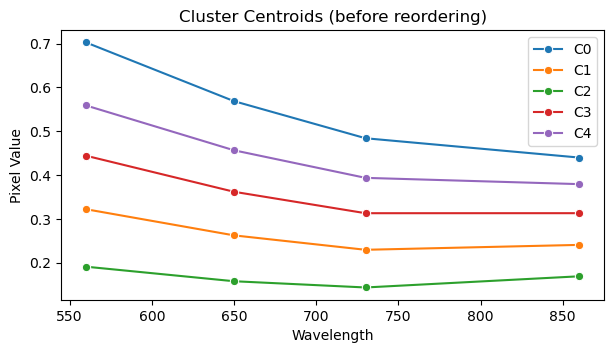

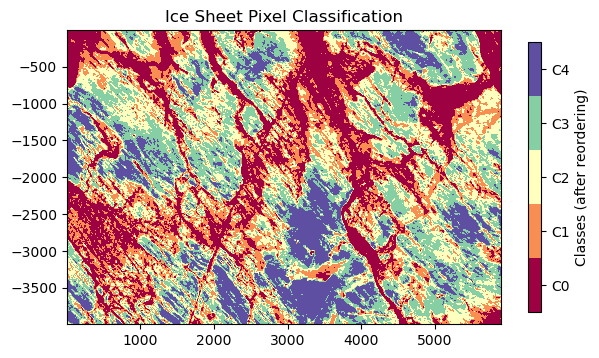

In [15]:
kmeans_low, index_full_label_xr_low, low_pcts, redefine_mapping_low = ds4114_process_all(lgi,lri,lrei,lni, clusters=5) 

2023-12-13 11:47:40.444348 Combining Data...
Clustering...
2023-12-13 11:47:57.986298 Adding Back and Reshaping...
Ordering an relabeling...
{0: 1981676, 1: 1344592, 2: 2256706, 3: 2200476, 4: 1373466}
4-->0
0-->1
2-->2
3-->3
1-->4
{0: 1373466, 1: 1981676, 2: 2256706, 3: 2200476, 4: 1344592}
2023-12-13 11:47:59.272702 Plotting...
Class 0 - 1,373,466 - 15.0%
Class 1 - 1,981,676 - 21.6%
Class 2 - 2,256,706 - 24.6%
Class 3 - 2,200,476 - 24.0%
Class 4 - 1,344,592 - 14.7%


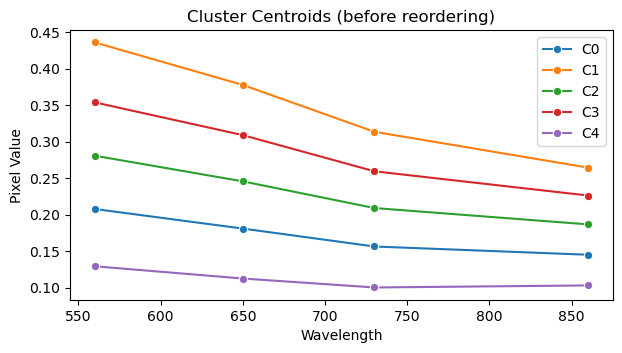

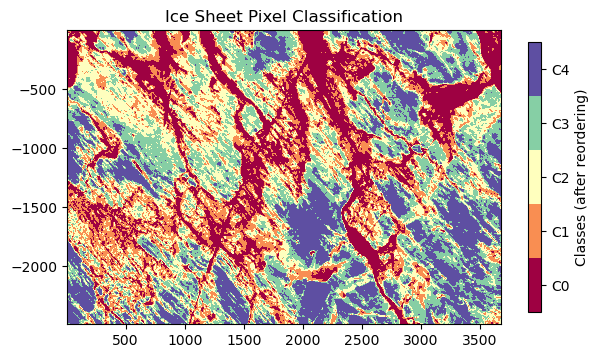

In [27]:
kmeans_mid, index_full_label_xr_mid, mid_pcts, redefine_mapping_mid = ds4114_process_all(mgi,mri,mrei,mni, clusters=5)

2023-12-13 11:48:01.026232 Combining Data...
Clustering...
2023-12-13 11:48:07.317760 Adding Back and Reshaping...
Ordering an relabeling...
{0: 890831, 1: 750290, 2: 557755, 3: 518921, 4: 800979}
3-->0
1-->1
4-->2
0-->3
2-->4
{0: 518921, 1: 750290, 2: 800979, 3: 890831, 4: 557755}
2023-12-13 11:48:07.646160 Plotting...
Class 0 - 518,921 - 14.7%
Class 1 - 750,290 - 21.3%
Class 2 - 800,979 - 22.8%
Class 3 - 890,831 - 25.3%
Class 4 - 557,755 - 15.9%


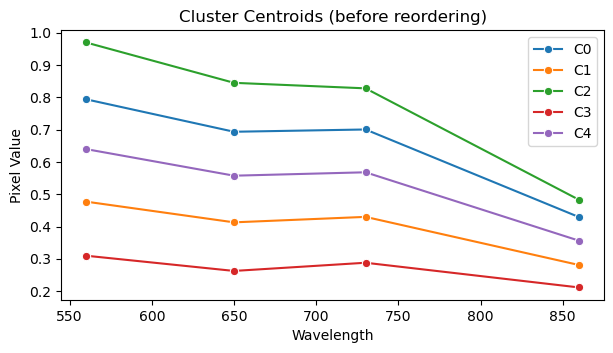

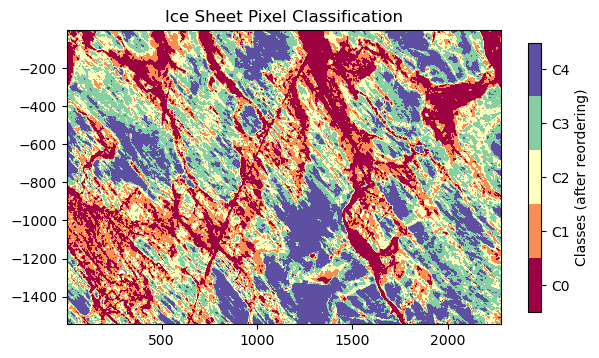

In [28]:
kmeans_top, index_full_label_xr_top, top_pcts, redefine_mapping_top = ds4114_process_all(tgi,tri,trei,tni, clusters=5)

### Compare

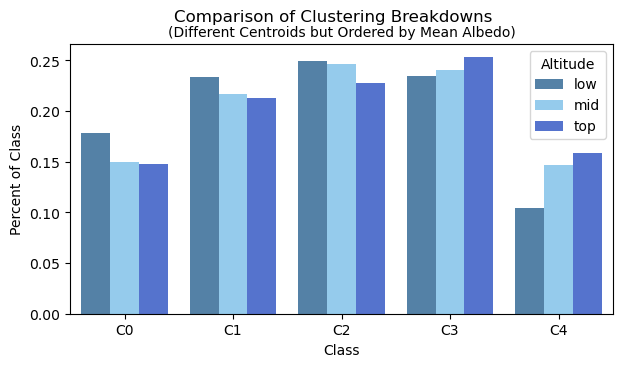

In [99]:
#even though cluster centroids are different, we can still compare between classes because they are ordered 
pct_comparison = pd.concat([low_pcts, mid_pcts, top_pcts], ignore_index=True, sort=False)
#fig = plt.figure(figsize=(7,3.5))
fig, ax = plt.subplots(1,1, figsize = (7,3.5))
palette = ['steelblue', 'lightskyblue', 'royalblue']
sns.barplot(x='Class', y='Percent', hue='Altitude', data=pct_comparison, palette = palette) 
plt.suptitle('Comparison of Clustering Breakdowns'); 
plt.title('(Different Centroids but Ordered by Mean Albedo)', size=10)
plt.xlabel("Class"); 
plt.ylabel("Percent of Class"); #non-null

In [102]:
pct_comparison

,Class,Percent,Altitude
0,C0,0.178289,low
1,C1,0.233343,low
2,C2,0.249689,low
3,C3,0.234737,low
4,C4,0.103942,low
5,C0,0.149992,mid
6,C1,0.216413,mid
7,C2,0.246448,mid
8,C3,0.240308,mid
9,C4,0.146839,mid


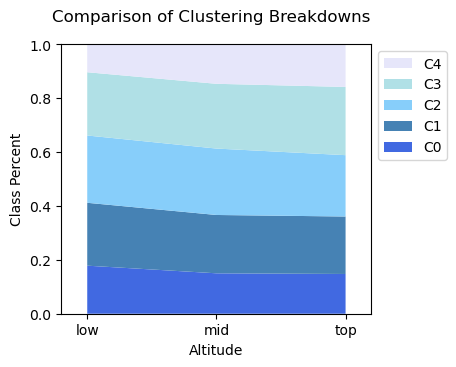

In [101]:
#viewed another way
plot_data = pct_comparison.pivot(index='Altitude',columns='Class',values='Percent')
palette = ['royalblue','steelblue', 'lightskyblue', 'powderblue', 'lavender']

fig, ax = plt.subplots(1,1, figsize = (4,3.5))
#plot_data.plot(kind='bar', stacked=True, ax=ax)
plt.stackplot(plot_data.index, plot_data.C0, plot_data.C1, plot_data.C2, plot_data.C3, plot_data.C4
                ,labels=['C0','C1','C2','C3','C4']
                , colors=palette)
plt.margins(x=0.1)
ax.set_ylim([0, 1])
plt.suptitle('Comparison of Clustering Breakdowns'); 
#plt.title('(different centroids but ordered by mean albedo)', size=10)
plt.xlabel("Altitude");
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1],bbox_to_anchor=(1,1), loc="upper left")
plt.ylabel("Class Percent"); #non-null

#### Plotting Side by Side

In [96]:
def plot_img_classes_subplot(my_xr_img, ax=None):
    """
    Custom function to plot image with class designation
    """
    if ax is None:
        ax = plt.gca()
        
    numb_classes = len(np.unique(my_xr_img.data)) 
    
    if np.isnan(my_xr_img.data).sum().item() > 0:
        numb_classes = numb_classes - 1   #-1 to exclude nan if exists since that is not a class
        
    cmap = discrete_cmap('Spectral', numb_classes) #prev. cm.get_cmap('Spectral', 4)    
    
    #plt.figure(figsize=(7,7))
    bp = ax.imshow(my_xr_img.data
           , extent=[my_xr_img.x.min(), my_xr_img.x.max()
                   , my_xr_img.y.min(), my_xr_img.y.max() ], origin="upper"
           ,cmap=cmap
          )
    
    #cbar = plt.colorbar(shrink=0.50)
    #cbar.set_label('Classes (after reordering)'); #ordering classes depends on relabeling and passing array in as same argument
    #cbar.set_ticks( np.arange((numb_classes-1)/(numb_classes*2),numb_classes-1,(numb_classes-1)/numb_classes) )  
    #cbar.set_ticklabels(["C"+str(x) for x in range(0,numb_classes)])
    #ax.title('Ice Sheet Pixel Classification'); 
    #plt.xlabel("X"); plt.ylabel("Y");
    
    return bp

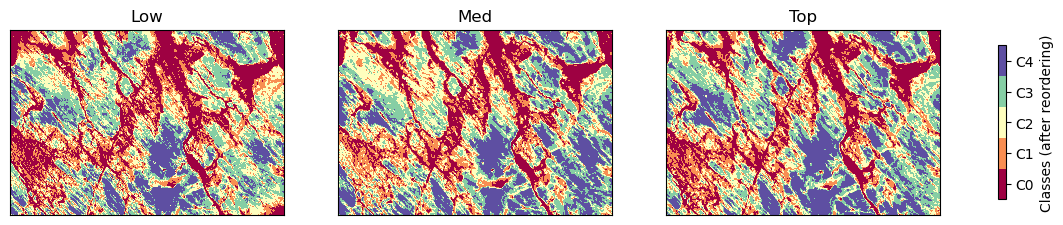

In [97]:
#fig, axs = plt.subplots(2)
#fig.suptitle('Vertically stacked subplots')
#plot_img_classes_subplot(index_full_label_xr_low)
numb_classes = 5

f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=False, figsize=(15,8)
                                       #,gridspec_kw={"width_ratios":[1,1,1, 0.5]}
                                      )
a = plot_img_classes_subplot(index_full_label_xr_low, ax1); ax1.title.set_text('Low')
b = plot_img_classes_subplot(index_full_label_xr_mid, ax2); ax2.title.set_text('Med')
c = plot_img_classes_subplot(index_full_label_xr_top, ax3); ax3.title.set_text('Top')
#d = plot_img_classes_subplot(index_full_label_xr_top, ax4)
for ax in [ax1,ax2,ax3]:
    ax.set_xticks([])
    ax.set_yticks([])

cmap = discrete_cmap('Spectral', numb_classes) 
cbar = plt.colorbar(c, ax=[ax1, ax2, ax3], orientation='vertical', shrink=0.25)
cbar.set_label('Classes (after reordering)'); #ordering classes depends on relabeling and passing array in as same argument
cbar.set_ticks( np.arange((numb_classes-1)/(numb_classes*2),numb_classes-1,(numb_classes-1)/numb_classes) )  
cbar.set_ticklabels(["C"+str(x) for x in range(0,numb_classes)])
#ax.title('Ice Sheet Pixel Classification'); 
#plt.xlabel("X"); plt.ylabel("Y");

#### Box Plot Comparison

In [132]:
def set_random_fraction_to_nan(data, keep_pct):
    #data[np.random.rand(*data.shape) < .8]=np.nan
    data[np.random.rand(data.shape[0]) > keep_pct]=np.nan  # Set X% of first dim randomly to nan
    return data

def print_histogram_random(my_xr, keep_pct, title=None):
    testdata = xr.apply_ufunc(set_random_fraction_to_nan, my_xr.transpose('yx','tensor_labels'), keep_pct
                              #, input_core_dims=[['tensor_labels','yx']], output_core_dims=[['tensor_labels','yx']]
                              #, input_core_dims=[['tensor_labels','yx']], output_core_dims=[['yx']]
                              , dask='parallelized').transpose('tensor_labels','yx')
    
    #print(testdata)

    sns.boxplot(x=560, y=testdata[0][~np.isnan(testdata[0])], color='green')
    sns.boxplot(x=650, y=testdata[1][~np.isnan(testdata[1])], color='red')
    sns.boxplot(x=730, y=testdata[2][~np.isnan(testdata[2])], color='pink')
    sns.boxplot(x=860, y=testdata[3][~np.isnan(testdata[3])], color='grey');
    if title is not None: plt.title(title) 
    plt.xlabel("Wavelength (nm)"); plt.ylabel("Pixel Value");

In [130]:
pixel_full = xr.merge([lgp,lrp,lrep,lnp], compat='minimal')
pixel_full_stack = pixel_full.to_array(dim='tensor_labels')
pixel_full_stack = pixel_full_stack.stack(yx=('y','x'))
pixel_full_stack = pixel_full_stack.transpose('yx','tensor_labels')
pixel_full_stack = pixel_full_stack.where( pixel_full_stack.any(dim = ['tensor_labels']) ) #make NaN when all zero across a channel (and altitude) to indicate black space
pixel_full_stack_noNaN = pixel_full_stack.dropna(dim="yx", how="any")

index_full = xr.merge([lgi,lri,lrei,lni], compat='minimal')
index_full_stack = index_full.to_array(dim='tensor_labels')
index_full_stack = index_full_stack.stack(yx=('y','x'))
index_full_stack = index_full_stack.transpose('yx','tensor_labels')
index_full_stack = index_full_stack.where( index_full_stack.any(dim = ['tensor_labels']) ) #make NaN when all zero across a channel (and altitude) to indicate black space
index_full_stack_noNaN = index_full_stack.dropna(dim="yx", how="any")

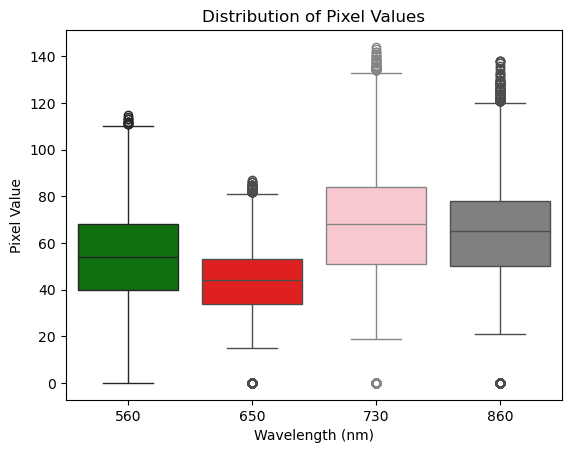

In [135]:
#test = xr.DataArray(np.ones((4,10)), dims=['tensor_labels','yx'])
#print_histogram_random(test, .2, 'Distribution of Pixel Values')
print_histogram_random(pixel_full_stack_noNaN, .2, 'Distribution of Pixel Values')

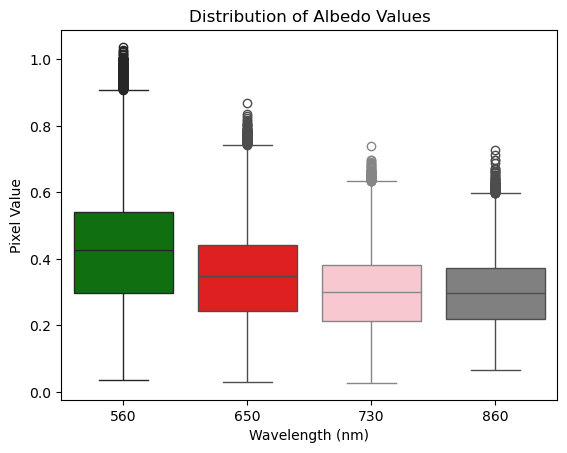

In [136]:
print_histogram_random(index_full_stack_noNaN, .2, 'Distribution of Albedo Values')

--------------------------------

## Data Exploration and Tuning (Outdated - To Ignore)

In [8]:
#just hardcoding filepath for testing
root = r'C:\Users\Devan\Downloads\greenland\calibration_test\map3ads_mosaic_index'
lgi_file = os.path.join(root,'map3a_ds_transparent_reflectance_green.tif') #naming: lgi = lower-green-index
lri_file = os.path.join(root,'map3a_ds_transparent_reflectance_red.tif')
lrei_file = os.path.join(root,'map3a_ds_transparent_reflectance_red edge.tif')
lni_file = os.path.join(root,'map3a_ds_transparent_reflectance_nir.tif')

lgi = file_to_xr(lgi_file, True, 'low', 'green')
lri = file_to_xr(lri_file, True, 'low', 'red')
lrei = file_to_xr(lrei_file, True, 'low', 'rededge')
lni = file_to_xr(lni_file, True, 'low', 'nir')

In [100]:
#combine
index_full = xr.merge([lgi,lri,lrei,lni], compat='minimal')
index_full_stack = index_full.to_array(dim='tensor_labels')
index_full_stack = index_full_stack.stack(yx=('y','x'))
index_full_stack = index_full_stack.transpose('yx','tensor_labels')
#index_full_stack

In [101]:
index_full_stack_noNaN = index_full_stack.dropna(dim="yx", how="any")
index_full_stack_noNaN

<xarray.DataArray (yx: 76700208, tensor_labels: 4)>
array([[0.09739731, 0.08870002, 0.06963062, 0.20270461],
       [0.09578427, 0.08915527, 0.06843036, 0.19211644],
       [0.09595562, 0.08917853, 0.07120589, 0.19209957],
       ...,
       [0.15955713, 0.15263496, 0.11878469, 0.26035714],
       [0.15742707, 0.15034595, 0.12410279, 0.26429585],
       [0.16128886, 0.14920476, 0.12657174, 0.26291996]], dtype=float32)
Coordinates:
    altitude       <U3 'low'
  * tensor_labels  (tensor_labels) object 'index-low-green' ... 'index-low-nir'
  * yx             (yx) object MultiIndex
  * y              (yx) int32 -1 -1 -1 -1 -1 ... -9912 -9912 -9912 -9912 -9912
  * x              (yx) int32 5202 5203 5204 5205 5206 ... 2080 2081 2082 2083

### Clustering

In [116]:
%%time
loss_dict = {}
hyperparam_range = range(2,7)
for n in hyperparam_range:
    print(datetime.datetime.now())
    kmeans = KMeans(n_clusters=n, random_state=0, n_init=1) #just using 1 initialization because faster and seems to work same as more
    kmeans.fit(index_full_stack_noNaN)
    loss_dict[n] = kmeans.inertia_
    print(kmeans.cluster_centers_)

2023-11-16 11:50:17.844088
[[0.15840635 0.14046317 0.12127181 0.13621052]
 [0.37307346 0.32242554 0.2672797  0.22814326]]
2023-11-16 11:51:37.110069
[[0.12463447 0.11105598 0.09719451 0.11994161]
 [0.42493555 0.3642063  0.29987395 0.24726361]
 [0.26630965 0.23404834 0.1974297  0.18629517]]
2023-11-16 12:01:56.128768
[[0.10623778 0.09497184 0.08397584 0.10963811]
 [0.33163446 0.28950754 0.24150425 0.21356353]
 [0.21484053 0.18965048 0.16156428 0.16455755]
 [0.46366534 0.39501035 0.32368845 0.26045448]]
2023-11-16 12:03:51.472427
[[0.09273991 0.08311763 0.07421002 0.10128424]
 [0.3685864  0.3199548  0.26521748 0.22782084]
 [0.17957115 0.1590632  0.13663876 0.14992139]
 [0.48660627 0.41273528 0.33773613 0.26828334]
 [0.2711501  0.23836099 0.20096739 0.18789089]]
2023-11-16 12:05:44.601422
[[0.15514432 0.13790104 0.11933617 0.13914068]
 [0.3959907  0.3415991  0.28200144 0.2371704 ]
 [0.23015659 0.20284766 0.17229304 0.16989638]
 [0.5048064  0.4275251  0.34930155 0.2749788 ]
 [0.30883288 0.

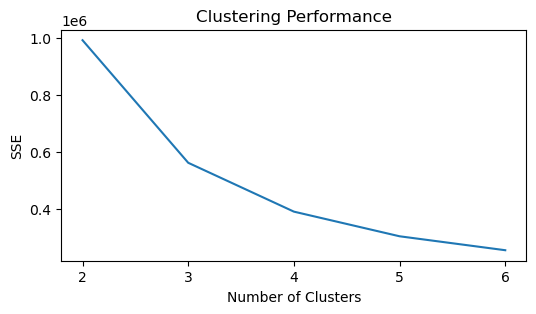

In [129]:
fig = plt.figure(figsize=(6,3))
plt.plot(list(loss_dict.keys()), list(loss_dict.values()))
plt.title('Clustering Performance'); plt.xlabel("Number of Clusters"); plt.ylabel("SSE");
plt.xticks(hyperparam_range);

In [130]:
#Not sure  - maybe 3 is good but will just use 5 to match CNN
total_clusters = 5
kmeans = KMeans(n_clusters=total_clusters, random_state=0, n_init=1)
kmeans.fit(index_full_stack_noNaN)

KMeans(n_clusters=5, n_init=1, random_state=0)

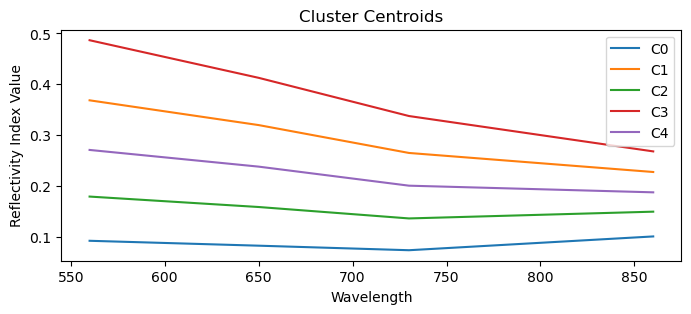

In [181]:
plot_kmeans(kmeans.cluster_centers_)

In [147]:
%%time
#add back to main dataframe
index_full_stack_noNaN_xr = index_full_stack_noNaN.to_dataset(name='index_full_stack_noNaN_albedo')
index_full_stack_noNaN_xr['index_full_stack_noNaN_class_label']= (['yx'], kmeans.labels_)
index_full_stack_noNaN_xr = index_full_stack_noNaN_xr.transpose('yx',...)
#index_full_stack_noNaN_xr

#unstack and sort for plotting properly with imshow
index_full_unstack_noNaN_label_xr = index_full_stack_noNaN_xr.index_full_stack_noNaN_class_label.unstack('yx')
index_full_unstack_noNaN_label_xr = index_full_unstack_noNaN_label_xr.sortby('x') 
index_full_unstack_noNaN_label_xr

CPU times: total: 15.4 s
Wall time: 15.5 s


<xarray.DataArray 'index_full_stack_noNaN_class_label' (y: 9912, x: 10631)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * y         (y) int32 -1 -2 -3 -4 -5 -6 ... -9908 -9909 -9910 -9911 -9912
  * x         (x) int32 1 2 3 4 5 6 7 ... 10626 10627 10628 10629 10630 10631
    altitude  <U3 'low'

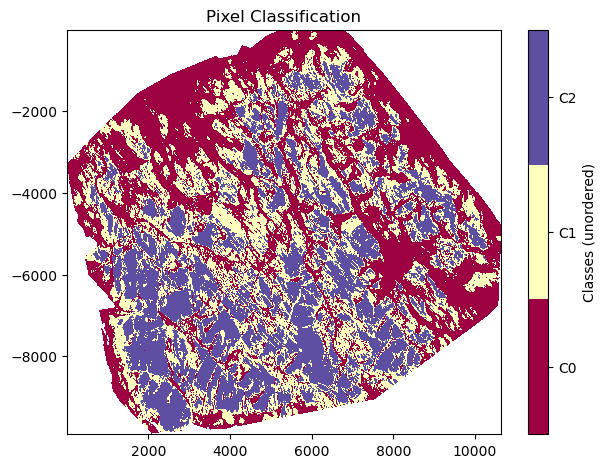

In [75]:
plot_img_classes(index_full_unstack_noNaN_label_xr)

In [182]:
#percetages of each class
display_percentages(index_full_unstack_noNaN_label_xr)

Class 0 - 15,704,574 - 20.5%
Class 1 - 16,102,069 - 21.0%
Class 2 - 18,918,417 - 24.7%
Class 3 - 8,194,990 - 10.7%
Class 4 - 17,780,158 - 23.2%

Null Data - 28,674,264 - 27.2% of Total Pixels


### Try on Pixel Values (not Albedo)

In [7]:
root = r'C:\Users\Devan\Downloads\greenland'
lgp = file_to_xr(os.path.join(root,'map3a_transparent_mosaic_green_low.tif'),  False, 'low', 'green')
lrp = file_to_xr(os.path.join(root,'map3a_transparent_mosaic_red_low.tif'),  False, 'low', 'red')
lrep = file_to_xr(os.path.join(root,'map3a_transparent_mosaic_red edge_low.tif'), False, 'low', 'rededge')
lnp = file_to_xr(os.path.join(root,'map3a_transparent_mosaic_nir_low.tif'),  False, 'low', 'nir')

In [8]:
pixel_full = xr.merge([lgp,lrp,lrep,lnp], compat='minimal')
pixel_full_stack = pixel_full.to_array(dim='tensor_labels')
pixel_full_stack = pixel_full_stack.stack(yx=('y','x'))
pixel_full_stack = pixel_full_stack.transpose('yx','tensor_labels')
pixel_full_stack = pixel_full_stack.where( pixel_full_stack.any(dim = ['tensor_labels']) ) #make NaN when all zero across a channel (and altitude) to indicate black space
pixel_full_stack_noNaN = pixel_full_stack.dropna(dim="yx", how="any")
pixel_full_stack_noNaN

<xarray.DataArray (yx: 76630009, tensor_labels: 4)>
array([[46., 35., 57., 55.],
       [47., 36., 57., 56.],
       [47., 35., 57., 57.],
       ...,
       [32., 32., 49., 51.],
       [31., 32., 48., 51.],
       [31., 32., 49., 51.]], dtype=float32)
Coordinates:
    altitude       <U3 'low'
  * tensor_labels  (tensor_labels) object 'pixel-low-green' ... 'pixel-low-nir'
  * yx             (yx) object MultiIndex
  * y              (yx) int32 -1 -1 -1 -1 -1 ... -9982 -9982 -9982 -9982 -9982
  * x              (yx) int32 5341 5342 5343 5344 5345 ... 2066 2067 2068 2069

In [17]:
total_clusters = 3 #using 5 was too chaotic for me
kmeans = KMeans(n_clusters=total_clusters, random_state=0, n_init=1)
kmeans.fit(pixel_full_stack_noNaN)

KMeans(n_clusters=3, n_init=1, random_state=0)

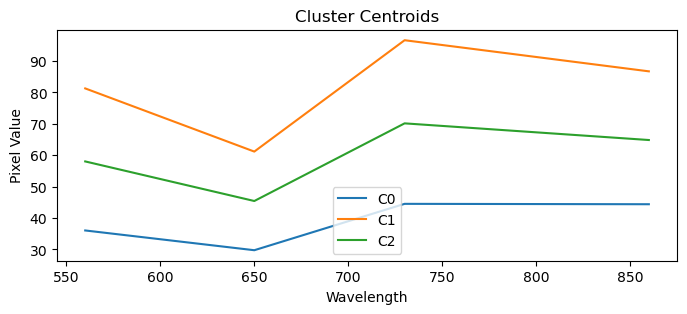

In [18]:
plot_kmeans(kmeans.cluster_centers_)

In [19]:
#add back to main dataframe
pixel_full_stack_noNaN_xr = pixel_full_stack_noNaN.to_dataset(name='pixel_full_stack_noNaN_value')
pixel_full_stack_noNaN_xr['pixel_full_stack_noNaN_class_label']= (['yx'], kmeans.labels_)
pixel_full_stack_noNaN_xr = pixel_full_stack_noNaN_xr.transpose('yx',...)
#pixel_full_stack_noNaN_xr

#unstack and sort for plotting properly with imshow
pixel_full_unstack_noNaN_label_xr = pixel_full_stack_noNaN_xr.pixel_full_stack_noNaN_class_label.unstack('yx')
pixel_full_unstack_noNaN_label_xr = pixel_full_unstack_noNaN_label_xr.sortby('x') 
#pixel_full_unstack_noNaN_label_xr

In [ ]:
plot_img_classes(pixel_full_unstack_noNaN_label_xr)
display_percentages(pixel_full_unstack_noNaN_label_xr)

### Repeat for Other Altitudes

In [ ]:
root = r'C:\Users\Devan\Downloads\greenland'
mgi = file_to_xr(os.path.join(root,'map3a_transparent_mosaic_green_mid.tif'),  True, 'mid', 'green')
mri = file_to_xr(os.path.join(root,'map3a_transparent_mosaic_red_mid.tif'),  True, 'mid', 'red')
mrei = file_to_xr(os.path.join(root,'map3a_transparent_mosaic_red edge_mid.tif'), True, 'mid', 'rededge')
mni = file_to_xr(os.path.join(root,'map3a_transparent_mosaic_nir_mid.tif'),  True, 'mid', 'nir')

In [ ]:
kmeans_mid, index_full_label_xr_mid = ds4114_process_all(mgi,mri,mrei,mni, clusters=4)

In [ ]:
#TBD for top height

### -----------Unused------------

0

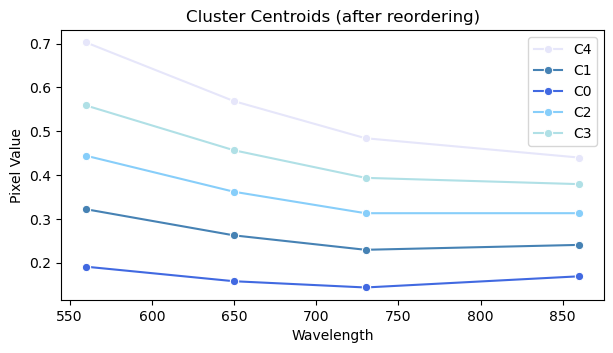

In [26]:
spectral_bands = [560,650,730,860] #from manufacturer
palette = ['royalblue','steelblue', 'lightskyblue', 'powderblue', 'lavender']
km_array = kmeans_low.cluster_centers_

plt.figure(figsize=(7,3.5))
for y in range(0,len(km_array)):
    reord = y*-1-1
    color = palette[( redefine_mapping_low[reord] )]
    #sns.lineplot(x=[560,650,730,860], y=km_array[y], label="C"+str( redefine_mapping_low[reord] ), marker='o', color=palette[reord])
    sns.lineplot(x=[560,650,730,860], y=km_array[y], label="C"+str( redefine_mapping_low[reord] ), marker='o', color=color)
plt.title('Cluster Centroids (after reordering)'); 
plt.xlabel("Wavelength"); 
plt.ylabel("Pixel Value");

In [32]:
pixel_full_stack_noNaN

<xarray.DataArray (yx: 76630009, tensor_labels: 4)>
array([[46., 35., 57., 55.],
       [47., 36., 57., 56.],
       [47., 35., 57., 57.],
       ...,
       [32., 32., 49., 51.],
       [31., 32., 48., 51.],
       [31., 32., 49., 51.]], dtype=float32)
Coordinates:
    altitude       <U3 'low'
  * tensor_labels  (tensor_labels) object 'pixel-low-green' ... 'pixel-low-nir'
  * yx             (yx) object MultiIndex
  * y              (yx) int32 -1 -1 -1 -1 -1 ... -9982 -9982 -9982 -9982 -9982
  * x              (yx) int32 5341 5342 5343 5344 5345 ... 2066 2067 2068 2069

In [70]:
np.random.rand(10) < .5

array([ True, False,  True, False,  True, False, False, False, False,
        True])

In [115]:
index_full_label_xr_top#.stack(yx=('y','x'))

<xarray.DataArray 'index_full_stack_noNaN_class_label' (y: 1544, x: 2279)>
array([[1, 1, 0, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [4, 4, 4, ..., 2, 1, 1],
       [4, 4, 4, ..., 2, 2, 1],
       [4, 4, 4, ..., 2, 2, 2]])
Coordinates:
  * y         (y) int32 -2 -3 -4 -5 -6 -7 ... -1541 -1542 -1543 -1544 -1545
  * x         (x) int32 2 3 4 5 6 7 8 9 ... 2274 2275 2276 2277 2278 2279 2280
    altitude  <U3 'top'

In [114]:
print_histogram_random(index_full_label_xr_top.stack(yx=('y','x')), 0.2) 

ValueError: cannot convert float NaN to integer

<xarray.DataArray (tensor_labels: 4, yx: 76630009)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
    altitude       <U3 'low'
  * tensor_labels  (tensor_labels) object 'pixel-low-green' ... 'pixel-low-nir'
  * yx             (yx) object MultiIndex
  * y              (yx) int32 -1 -1 -1 -1 -1 ... -9982 -9982 -9982 -9982 -9982
  * x              (yx) int32 5341 5342 5343 5344 5345 ... 2066 2067 2068 2069


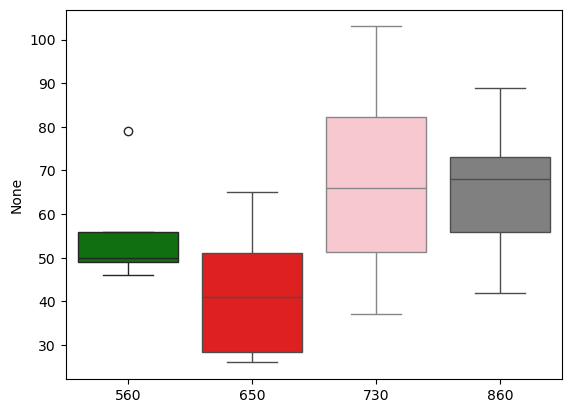

In [105]:
test = xr.DataArray(np.ones((4,10)), dims=['tensor_labels','yx'])
#print_histogram_random(test, .2)
print_histogram_random(pixel_full_stack_noNaN, .2)

<xarray.DataArray (tensor_labels: 4, yx: 76700208)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
    altitude       <U3 'low'
  * tensor_labels  (tensor_labels) object 'index-low-green' ... 'index-low-nir'
  * yx             (yx) object MultiIndex
  * y              (yx) int32 -1 -1 -1 -1 -1 ... -9912 -9912 -9912 -9912 -9912
  * x              (yx) int32 5202 5203 5204 5205 5206 ... 2080 2081 2082 2083


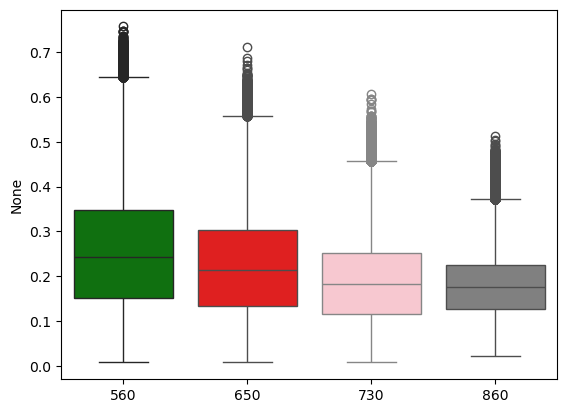

In [106]:
print_histogram_random(index_full_stack_noNaN, .2)

CPU times: total: 1min 31s
Wall time: 1min 31s


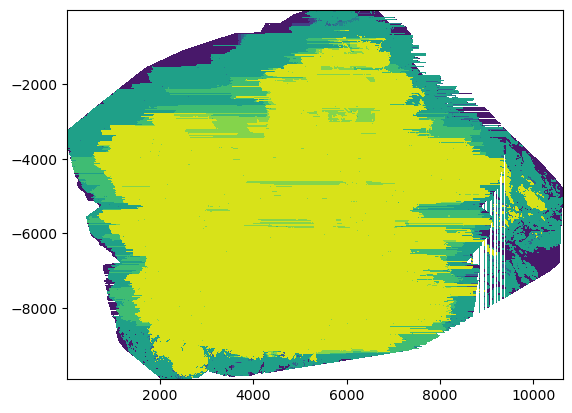

In [9]:
%%time
#plt.contourf(test_noNan_unstack.x,test_noNan_unstack.y,test_noNan_unstack.data) 

In [130]:
redefine_classes(kmeans_low, index_full_label_xr_low) #should be 0->0;1->3;2->1,3->2; {0: 1909225, 1: 2756618, 2: 1926595, 3: 2564478}

{0: 1909225, 1: 2564478, 2: 2756618, 3: 1926595}
[(0, 0.1437433), (2, 0.23773696), (3, 0.3249727), (1, 0.41986507)]
0-->0
2-->1
3-->2
1-->3
{-1: 0, -3: 1, -4: 2, -2: 3}
{0: 1909225, 1: 2756618, 2: 1926595, 3: 2564478}


array([[0, 0, 3, ..., 0, 0, 0],
       [3, 3, 3, ..., 0, 0, 0],
       [3, 3, 3, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 3, 3, 3],
       [1, 1, 1, ..., 3, 3, 3],
       [1, 1, 1, ..., 3, 3, 3]])

2023-11-23 16:05:38.862945 Combinig Data...
Clustering...
2023-11-23 16:08:14.562444Adding Back and Reshaping...
2023-11-23 16:08:27.707201 Plotting...
Class 0 - 28,374,357 - 37.0%
Class 1 - 20,031,346 - 26.1%
Class 2 - 28,294,505 - 36.9%

Null Data - 28,674,264 - 27.2% of Total Pixels


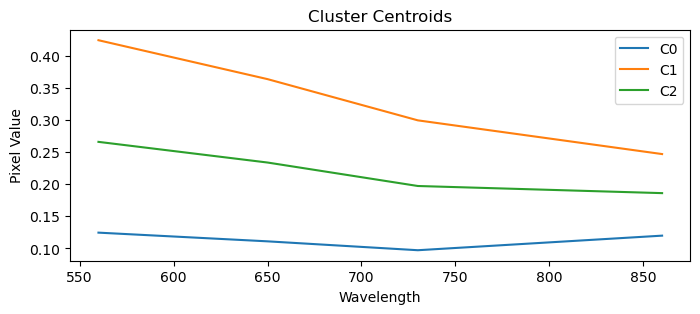

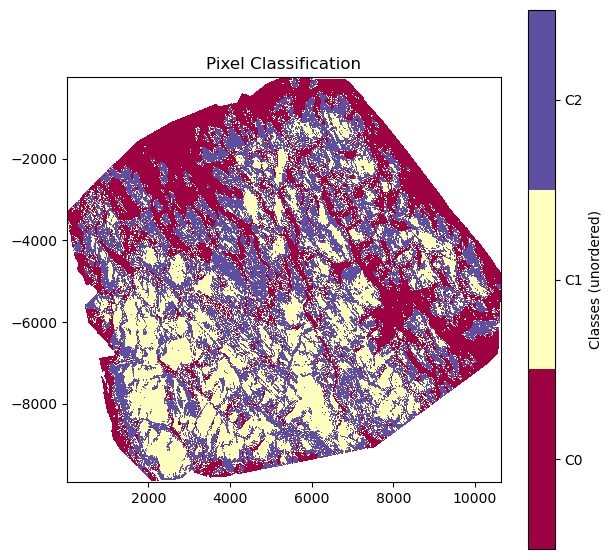

In [12]:
kmeans, index_full_unstack_noNaN_label_xr = ds4114_process_all(lgi,lri,lrei,lni, clusters=4)

2023-11-23 16:58:45.124375 Combinig Data...
Clustering...
2023-11-23 17:01:34.526367 Adding Back and Reshaping...
{0.0: 28374354, 1.0: 20031354, 2.0: 28294500, nan: 28674264}
0-->0
1-->2
2-->1
{0.0: 28374354, 1.0: 28294500, 2.0: 20031354, nan: 28674264}
2023-11-23 17:02:13.505219 Plotting...
Class 0 - 28,374,354 - 37.0%
Class 1 - 28,294,500 - 36.9%
Class 2 - 20,031,354 - 26.1%

Null Data - 28,674,264 - 27.2% of Total Pixels


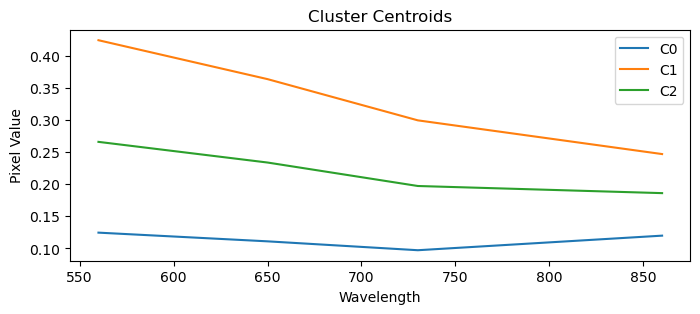

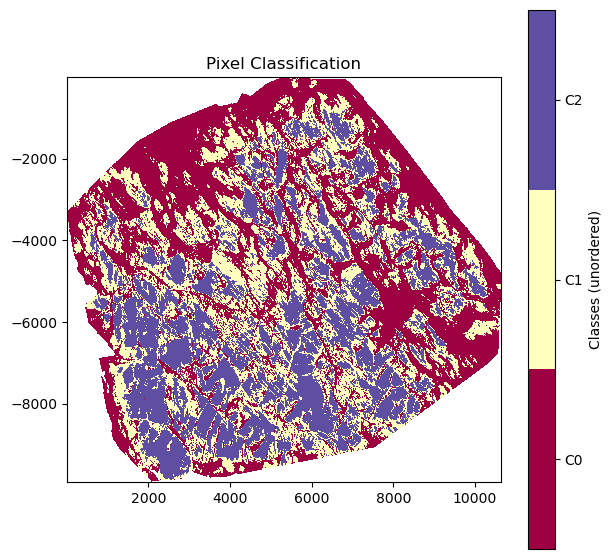

In [72]:
kmeans2, index_full_unstack_noNaN_label_xr2 = ds4114_process_all(lgi,lri,lrei,lni, clusters=3)

In [65]:
test2 = test.to_numpy()
unique, counts = np.unique(test2, return_counts=True)
print(dict(zip( unique, counts  )) )

{-3.0: 28294505, -2.0: 20031346, -1.0: 28374357, nan: 28674264}
